In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt


## 데이터 취득

In [2]:
# https://drive.google.com/file/d/1-HdykExDqZrR5FO9a0vl2c0koPqJB-8F/view?usp=sharing
# https://drive.google.com/file/d/1kC0uzIo2mYPZik1hhzEsUpvGZJbUV9MM/view?usp=sharing

import gdown, os, zipfile

file_id = '1kC0uzIo2mYPZik1hhzEsUpvGZJbUV9MM'
gdown.download(f'http://drive.google.com/uc?id={file_id}', 'file.zip', quiet=False)

dir = 'hair-loss'
os.makedirs(dir, exist_ok=True)

with zipfile.ZipFile('file.zip', 'r') as z:
  z.extractall(dir)

Downloading...
From (original): http://drive.google.com/uc?id=1kC0uzIo2mYPZik1hhzEsUpvGZJbUV9MM
From (redirected): https://drive.google.com/uc?id=1kC0uzIo2mYPZik1hhzEsUpvGZJbUV9MM&confirm=t&uuid=30245923-8179-4f29-af01-31a8ec155283
To: /content/file.zip
100%|██████████| 1.25G/1.25G [00:06<00:00, 196MB/s]


## 메타데이터

In [3]:
import os

def load_data(base_dir = 'hair-loss/Training'):
  images = []
  labels = []
  # class_names = []


  for class_name in os.listdir(base_dir):
    class_name_path = os.path.join(base_dir, class_name)

    if os.path.isdir(class_name_path):
      print(len(os.listdir(class_name_path)))
      for image_name in os.listdir(class_name_path):
        image_path = os.path.join(class_name_path, image_name)
        images.append(image_path)
        labels.append(int(class_name))

  return images, np.array(labels)

images, labels  = load_data()
labels.shape



836
235
3797
534


(5402,)

### 이미지 resize

In [4]:
import tensorflow as tf
import cv2

# 리사이즈 크기 설정
IMAGE_SIZE = (224, 224)

# 결과 저장 리스트
processed_images = []

# 이미지 경로 리스트 반복 - 이미지 읽기
for image_path in images:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMAGE_SIZE)
    processed_images.append(image)

# 최종 이미지
images = np.array(processed_images)

print(images.shape)
print(labels.shape)

(5402, 224, 224, 3)
(5402,)


In [5]:
from collections import Counter

print(Counter(labels))

Counter({2: 3797, 3: 836, 0: 534, 1: 235})


### 데이터셋 분할

In [6]:
from sklearn.model_selection import train_test_split

# 훈련 / 테스트셋 분할
tr_images, test_images, tr_labels, test_labels = train_test_split(images, labels, test_size=0.1, random_state=0, stratify=labels)

tr_images.shape, tr_labels.shape, test_images.shape, test_labels.shape


((4861, 224, 224, 3), (4861,), (541, 224, 224, 3), (541,))

In [7]:
tr_labels.shape

(4861,)

In [8]:
# 훈련 / 검증용 분할
tr_images, val_images, tr_labels, val_labels = train_test_split(tr_images, tr_labels, test_size=0.2, random_state=0, stratify=tr_labels)

tr_images.shape, tr_labels.shape, val_images.shape, val_labels.shape, test_images.shape, test_labels.shape

((3888, 224, 224, 3),
 (3888,),
 (973, 224, 224, 3),
 (973,),
 (541, 224, 224, 3),
 (541,))

In [9]:
from collections import Counter

print(Counter(tr_labels), Counter(val_labels), Counter(test_labels))

Counter({2: 2733, 3: 601, 0: 385, 1: 169}) Counter({2: 684, 3: 151, 0: 96, 1: 42}) Counter({2: 380, 3: 84, 0: 53, 1: 24})


## Sequence Subclass 작성

In [10]:
# 사진 - 640 x 480
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
import cv2



class HairLossSequence(Sequence):
  def __init__(self, images, labels, batch_size=32, image_size=224, augmentor=None, preprocess_function=None, shuffle=True):
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.image_size = image_size
    self.augmentor = augmentor
    self.shuffle = shuffle
    self.preprocess_function = preprocess_function
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, index):
    start = index * self.batch_size
    end = (index + 1) * self.batch_size
    this_batch_images = self.images[start:end]
    batch_labels = self.labels[start:end] if self.labels is not None else None

    batch_images = np.zeros((this_batch_images.shape[0], 224, 224, 3), dtype=np.float32)


    for i in range(this_batch_images.shape[0]):
      image = this_batch_images[i]

      # 스케일링
      if self.preprocess_function is not None:
        imag = self.preprocess_function(image)

      batch_images[i] = image
    return (batch_images, batch_labels) if self.labels is not None else batch_images

  def on_epoch_end(self):
    if self.shuffle:
      self.images, self.labels = shuffle(self.images, self.labels)


# 학습/검증/평가 데이터셋 별로 Sequence 객체 생성

In [11]:
# 이미지증강/shuffle 적용
import albumentations as A

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

augmentor = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5)
])
# augmentor=augmentor, shuffle=True

tr_seq = HairLossSequence(tr_images, tr_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE) # 증강은 훈련셋만
val_seq = HairLossSequence(val_images, val_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)
test_seq = HairLossSequence(test_images, test_labels, image_size = IMAGE_SIZE, batch_size=BATCH_SIZE)

len(tr_seq), len(val_seq), len(test_seq)

# print(type(tr_seq[0]))

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(122, 31, 17)

In [12]:
# import tensorflow as tf
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model

# # 기존 ResNet50 기반 모델 정의
# def create_pretained_resnet50_with_se(input_shape=(224, 224, 3), num_classes=4):
#     base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')

#     # SE 블록 추가
#     x = base_model.output
#     x = se_block(x)  # SE 블록 삽입

#     # 추가 레이어
#     x = layers.GlobalAveragePooling2D()(x)
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.5)(x)
#     output = layers.Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=base_model.input, outputs=output)

#     return model
# # SE 블록 정의
# def se_block(input_tensor, reduction_ratio=16):
#     channel_axis = -1
#     filters = input_tensor.shape[channel_axis]
#     se_shape = (1, 1, filters)

#     se = layers.GlobalAveragePooling2D()(input_tensor)
#     se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
#     se = layers.Dense(filters, activation='sigmoid')(se)
#     se = layers.Reshape(se_shape)(se)

#     return layers.Multiply()([input_tensor, se])

# model = create_pretained_resnet50_with_se()
# model.summary()


In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply
# from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout


# def se_block(input_tensor, reduction=16):
#     """Squeeze-and-Excitation 블록 구현"""
#     # Get the number of channels
#     channels = input_tensor.shape[-1]
#     # Squeeze: Global Average Pooling
#     se = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
#     # Excitation: Fully connected layers
#     se = tf.keras.layers.Dense(channels // reduction, activation='relu')(se)
#     se = tf.keras.layers.Dense(channels, activation='sigmoid')(se)
#     # Reshape to match input tensor dimensions
#     se = Reshape((1, 1, channels))(se)
#     se = Multiply()([input_tensor, se])
#     return se


# # ResNet50 base model
# base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# # 입력 텐서 정의
# input_tensor = base_model.input
# x = input_tensor

# # ResNet50 레이어를 순회하며 SE 블록 삽입
# for layer in base_model.layers:
#     x = layer(x)  # 기존 레이어 연결
#     # Conv 레이어 뒤에 SE 블록 추가
#     if isinstance(layer, tf.keras.layers.Conv2D):
#         x = se_block(x)

# # Global Average Pooling 및 Fully Connected Layer 추가
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
# output_tensor = Dense(4, activation='softmax')(x)  # 분류할 클래스 수에 맞게 수정

# # 최종 모델 생성
# model = Model(inputs=input_tensor, outputs=output_tensor)

# # 모델 구조 출력
# model.summary()


In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Reshape, Multiply

# SE 블록 정의
def se_block(input_tensor, reduction=16):
    """Squeeze-and-Excitation 블록 구현"""
    channels = input_tensor.shape[-1]
    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    # Excitation: Fully connected layers
    se = Dense(channels // reduction, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    # Reshape to match input tensor dimensions
    se = Reshape((1, 1, channels))(se)
    se = Multiply()([input_tensor, se])
    return se

# ResNet50의 기본 블록 구조
def ResNet50_with_SE(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # 초기 Conv2D 및 MaxPooling
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Residual Block 정의
    def residual_block(x, filters, strides=(1, 1)):
        shortcut = x
        # 스트라이드를 적용한 경우 shortcut 크기 맞추기
        if strides != (1, 1):
            shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding="same")(shortcut)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Conv2D(filters, (3, 3), strides=strides, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)

        # SE 블록 추가
        x = se_block(x)

        # 스킵 연결
        x = layers.add([x, shortcut])
        x = layers.ReLU()(x)
        return x

    # 3개의 Residual Block 추가
    x = residual_block(x, 64)
    x = residual_block(x, 128, strides=(2, 2))
    x = residual_block(x, 256, strides=(2, 2))
    x = residual_block(x, 512, strides=(2, 2))

    # Global Average Pooling 및 FC Layer
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # 모델 생성
    model = models.Model(inputs, outputs)
    return model

# 모델 생성
model = ResNet50_with_SE(input_shape=(224, 224, 3), num_classes=4)
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization_2… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ multiply[0][0],        │
│                           │                        │                │ max_pooling2d[0][0]    │
├──────────────────────

 Total params: 4,961,024 (18.92 MB)

 Trainable params: 4,955,264 (18.90 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [15]:
import tensorflow as tf
tf.version.VERSION

'2.17.1'

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
# 모델체크포인트 콜백
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight

# 모델 컴파일
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# model_checkpoint_cb = ModelCheckpoint(
#     filepath='./results/checkpoint.{epoch:02d}-{val_loss:.2f}.keras',
#     save_weights_only=False, # 모델로 저장옵션
#     save_best_only=True, # 이전 epoch보다 좋은 성능을 낸 경우만 저장
#     monitor='val_loss',
#     verbose=1
# )

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau_cb = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)


# 클래스 불균형에 맞게 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(tr_labels), y=tr_labels)

# 계산된 class weights를 딕셔너리 형태로 변환
class_weight_dict = dict(enumerate(class_weights))


# 학습
history = model.fit(
    tr_seq,
    epochs=30,
    validation_data=val_seq,
    callbacks=[early_stopping_cb, reduce_lr_on_plateau_cb],
    class_weight=class_weight_dict  # 클래스 가중치를 학습에 반영)
)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 207ms/step - accuracy: 0.4355 - loss: 1.1906 - val_accuracy: 0.1264 - val_loss: 7.0354 - learning_rate: 0.0010
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5191 - loss: 0.8805 - val_accuracy: 0.2395 - val_loss: 2.1943 - learning_rate: 0.0010
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5104 - loss: 0.8962 - val_accuracy: 0.3186 - val_loss: 1.5273 - learning_rate: 0.0010
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5434 - loss: 0.8118 - val_accuracy: 0.0987 - val_loss: 7.5435 - learning_rate: 0.0010
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5642 - loss: 0.8155 - val_accuracy: 0.1583 - val_loss: 3.5927 - learning_rate: 0.0010
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5958 - loss: 0.7256 - val_accuracy: 0.3844 - val_loss: 1.4653 - learning_rate: 0.0010
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.5978 - loss: 0.6955 - va

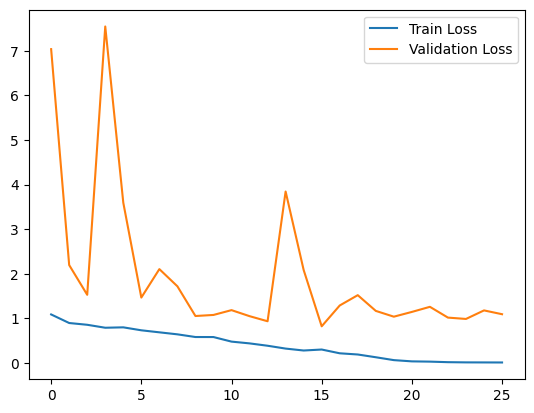

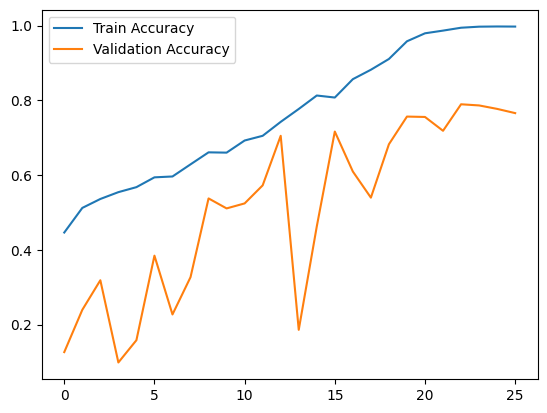

In [17]:
# 학습결과 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [18]:
# 평가
loss, accuracy = model.evaluate(test_seq)
print(f'loss: {loss:.4f}, accuracy: {accuracy:.4f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.6996 - loss: 0.8796
loss: 0.8951, accuracy: 0.6987


In [19]:
# 모델 저장
model.save(f'ResNet50.loss-{loss:.2f}-accuracy-{accuracy:.2f}.h5')  # .h5 확장자 파일로 저장

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 112, 112, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 112, 112, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 56, 56, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 56, 56, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 56, 56, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 64)             │              0 │ batch_normalization_2… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4)              │            260 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            320 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 64)       │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 56, 56, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 64)     │              0 │ multiply[0][0],        │
│                           │                        │                │ max_pooling2d[0][0]    │
├──────────────────────

 Total params: 14,871,554 (56.73 MB)

 Trainable params: 4,955,264 (18.90 MB)

 Non-trainable params: 5,760 (22.50 KB)

 Optimizer params: 9,910,530 (37.81 MB)

In [30]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, img_array, layer_name, class_idx):
    """
    Grad-CAM 계산 및 시각화
    :param model: 학습된 모델
    :param img_array: 입력 이미지 배열 (모양: (1, height, width, channels))
    :param layer_name: Grad-CAM을 적용할 레이어 이름
    :param class_idx: 관심 클래스의 인덱스
    :return: Grad-CAM 열맵
    """
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # 특성 맵에 대한 손실의 그래디언트 계산
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # 특성 맵에 가중치를 곱하고 평균
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # ReLU를 적용하여 음수값 제거
    heatmap = np.maximum(heatmap, 0)

    # 열맵을 [0, 1]로 정규화
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

def display_grad_cam(image, heatmap, alpha=0.4):
    """
    Grad-CAM 열맵 시각화
    :param image: 원본 이미지
    :param heatmap: Grad-CAM 열맵
    :param alpha: 열맵의 투명도
    """
    # 열맵 크기를 원본 이미지에 맞게 조정
    heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 원본 이미지와 합성
    superimposed_img = heatmap * alpha + image
    plt.imshow(superimposed_img.astype("uint8"))
    plt.axis('off')
    plt.show()

# 예시: Grad-CAM 계산 및 시각화
def apply_grad_cam_example(model, image_path, target_layer, class_idx):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_array = np.expand_dims(img_resized / 255.0, axis=0)

    heatmap = grad_cam(model, img_array, target_layer, class_idx)
    display_grad_cam(img, heatmap)



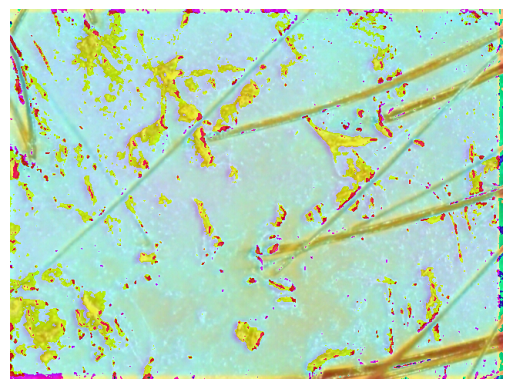

In [38]:
apply_grad_cam_example(
    model=model,
    image_path='/content/hair-loss/Training/2/0013_A2LEBJJDE00060O_1603341963457_4_LH.jpg',
    target_layer="conv2d",
    class_idx=2  # 관심 클래스 인덱스
)


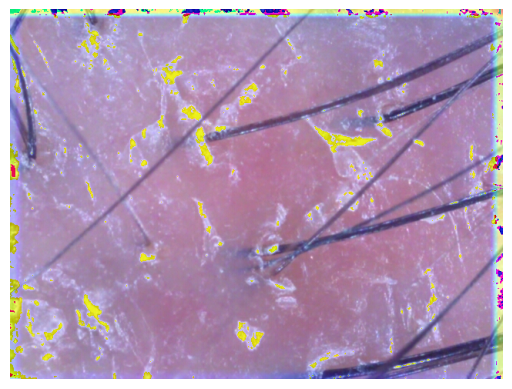

In [39]:
apply_grad_cam_example(
    model=model,
    image_path='/content/hair-loss/Training/2/0013_A2LEBJJDE00060O_1603341963457_4_LH.jpg',
    target_layer="conv2d_1",
    class_idx=2  # 관심 클래스 인덱스
)


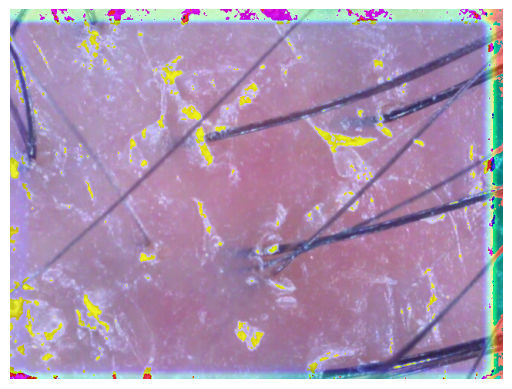

In [40]:
apply_grad_cam_example(
    model=model,
    image_path='/content/hair-loss/Training/2/0013_A2LEBJJDE00060O_1603341963457_4_LH.jpg',
    target_layer="conv2d_2",
    class_idx=2  # 관심 클래스 인덱스
)


<ipython-input-30-66668f4ece4d>:47: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


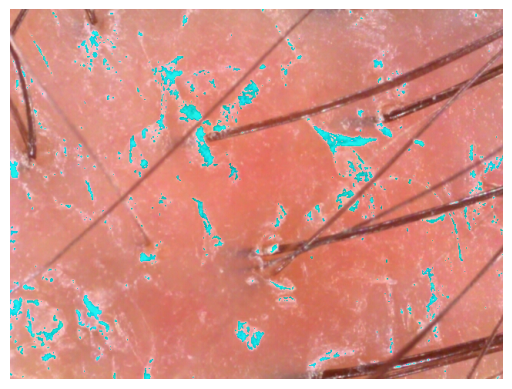

In [35]:
apply_grad_cam_example(
    model=model,
    image_path='/content/hair-loss/Training/2/0013_A2LEBJJDE00060O_1603341963457_4_LH.jpg',
    target_layer="conv2d_4",  # ResNet50의 마지막 Conv 레이어
    class_idx=2  # 관심 클래스 인덱스
)


<ipython-input-30-66668f4ece4d>:47: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


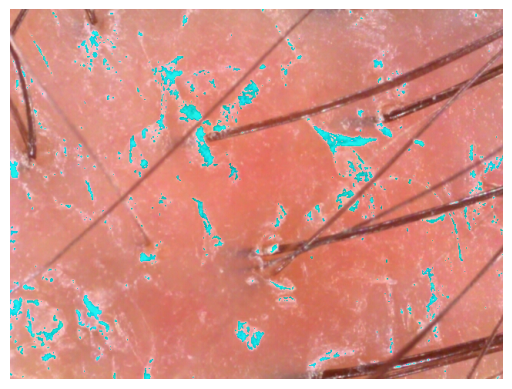

In [36]:
apply_grad_cam_example(
    model=model,
    image_path='/content/hair-loss/Training/2/0013_A2LEBJJDE00060O_1603341963457_4_LH.jpg',
    target_layer="conv2d_5",  # ResNet50의 마지막 Conv 레이어
    class_idx=2  # 관심 클래스 인덱스
)


<ipython-input-30-66668f4ece4d>:47: RuntimeWarning: invalid value encountered in cast
  heatmap = np.uint8(255 * heatmap)


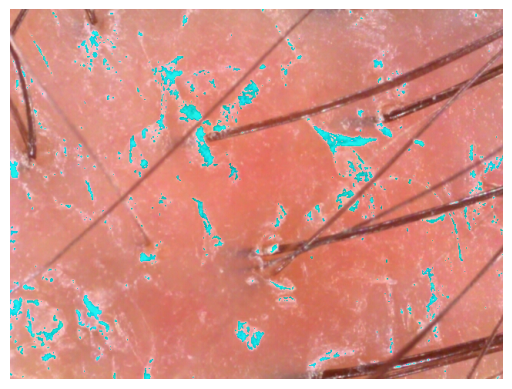

In [37]:
apply_grad_cam_example(
    model=model,
    image_path='/content/hair-loss/Training/2/0013_A2LEBJJDE00060O_1603341963457_4_LH.jpg',
    target_layer="conv2d_3",  # ResNet50의 마지막 Conv 레이어
    class_idx=2  # 관심 클래스 인덱스
)
